In [1]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 10
MEDIUM = 14
LARGE = 20
THICK = 4
THIN = 3
WIDE_FIG = (20,6)


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=SMALL, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import imageio
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import LogNorm

# Project source files
from utils import *
from ols import *
from ridge import *
from lasso import *

/home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 5
VAR_EPS = .03

x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

polynomial_orders = list(range(MAX_POLY_ORDER+1))

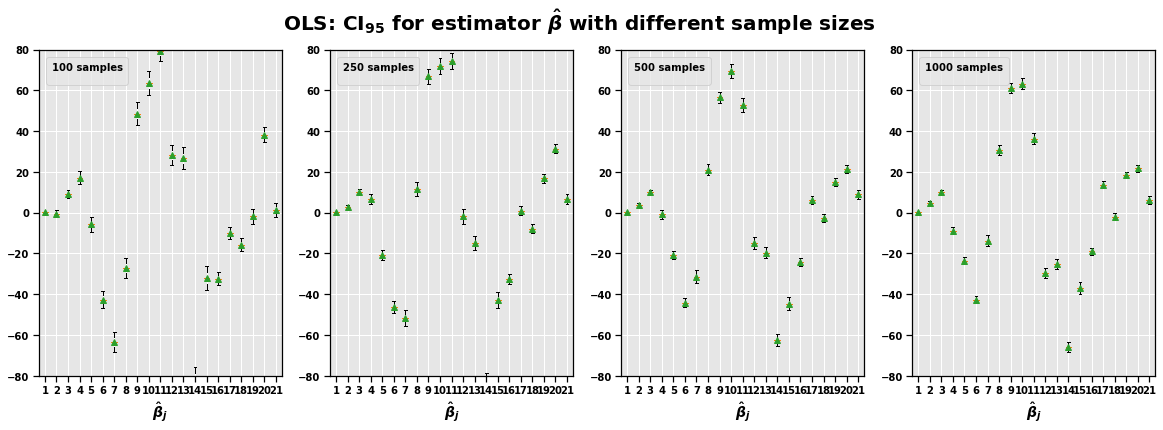

In [4]:
'''Plot OLS Confidence interval'''

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS: CI$_{95}$ for estimator $\hat{\beta}$ with different sample sizes", fontsize=LARGE, weight='bold')

ylim = (-80,80)

scaler = skl.preprocessing.StandardScaler(with_std=False)
plots = [141,142,143,144]
samples = [100,250,500,1000]

for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    X_down = X[:sn]
    z_down = z[:sn]
    X_down = scaler.fit_transform(X_down)
    X_down[:,0] = 1
    plt.boxplot(beta_hat_confidence_intervals(X_down, z_down, VAR_EPS, ci=95), showbox=False, showmeans=True)
    plt.ylim(*ylim)
    plt.legend([], title=f'{sn} samples', title_fontsize=SMALL, loc='upper left')
    plt.xlabel(r"$\hat{\beta}_j$")

plt.show()

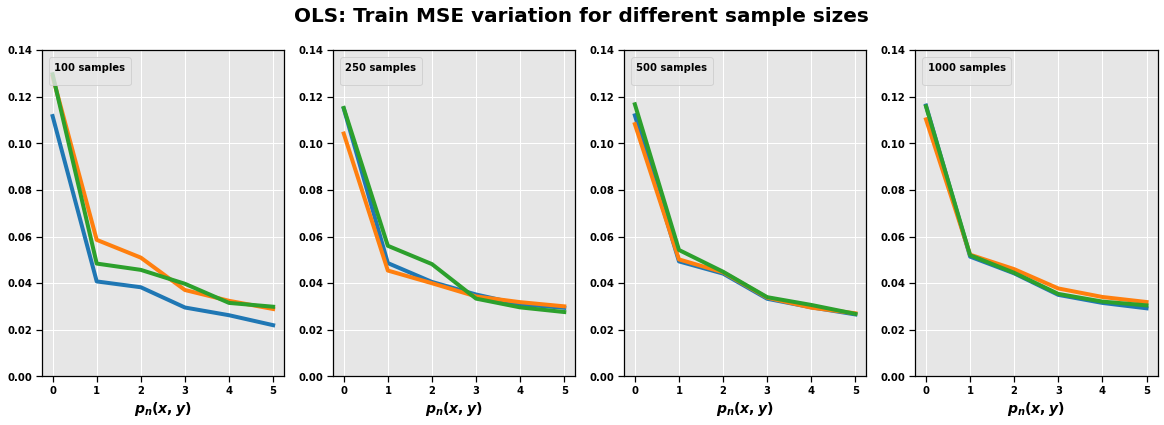

In [5]:
'''Plot OLS MSE for different sample sizes'''

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS: Train MSE variation for different sample sizes", fontsize=LARGE, weight='bold')
ylim = (0,.14)

scaler = skl.preprocessing.StandardScaler(with_std=False)
plots = [141,142,143,144]
samples = [100,250,500,1000]
ols_mse = np.ndarray(len(polynomial_orders))

random_state = 0
for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    for i in range(3):
        x, y = randmesh(sn=sn, random_state=i)
        X = make_design_matrix(x, y, pn=5)
        z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)
        for pn in polynomial_orders:
            Xpn = truncate_to_poly(X, pn)
            Xpn = scaler.fit_transform(Xpn)
            Xpn[:,0] = 1
            beta_hat = np.linalg.inv(Xpn.T @ Xpn) @ Xpn.T @ z
            z_tilde = Xpn @ beta_hat
            ols_mse[pn] = mse(z, z_tilde)
        plt.plot(polynomial_orders, ols_mse)
    plt.ylim(*ylim)
    plt.legend([], title=f'{sn} samples', title_fontsize=SMALL, loc='upper left')
    plt.xlabel(r"$p_n(x,y)$")

plt.show()

In [6]:
'''OLS Regression data set'''

NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
VAR_EPS = .03

x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

polynomial_orders = list(range(MAX_POLY_ORDER+1))

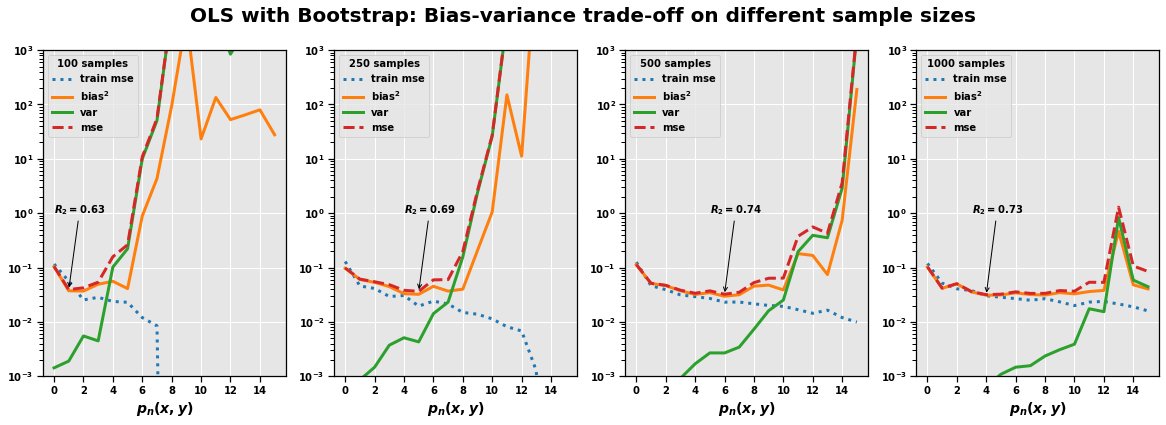

In [7]:
'''Plotting OLS with Bootstrap'''

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS with Bootstrap: Bias-variance trade-off on different sample sizes", fontsize=LARGE, weight='bold')
ylim = (1E-3, 1E3)

plots = [141,142,143,144]
samples = [100,250,500,1000]

for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    X_down = X[:sn]
    z_down = z[:sn]
    f_down = f[:sn]
    ols_bs_df = run_ols_bootstrap(X_down, z_down, f_down, polynomial_orders=polynomial_orders, train_size=.7, bootstraps=25)
    plt.plot(polynomial_orders, ols_bs_df['train_mse'], ':', linewidth=THIN)
    plt.plot(polynomial_orders, ols_bs_df['test_bias'], linewidth=THIN)
    plt.plot(polynomial_orders, ols_bs_df['test_var'], linewidth=THIN)
    plt.plot(polynomial_orders, ols_bs_df['test_mse'], '--', linewidth=THIN)
    plt.legend(['train mse', 'bias$^2$', 'var', 'mse'], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    plt.ylim(*ylim)
    plt.xlabel(r"$p_n(x,y)$")
    plt.yscale('log')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # R2 annotation 
    best_idx = ols_bs_df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = ols_bs_df['test_mse'].min()
    xytext = (best_mse_pn-1, 1)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(ols_bs_df['test_mse'], z_down)
    plt.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

plt.show()

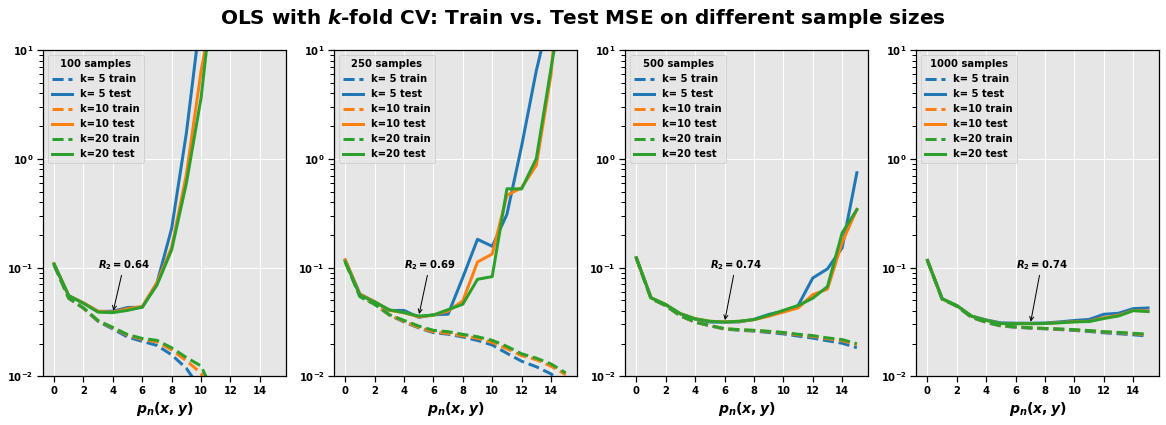

In [8]:
'''Plotting OLS with CV'''

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS with $k$-fold CV: Train vs. Test MSE on different sample sizes", fontsize=LARGE, weight='bold')
ylim = (1E-2, 1E1)

plots = [141,142,143,144]
samples = [100,250,500,1000]

for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    X_down = X[:sn]
    z_down = z[:sn]
    legend = []
    for i, k in enumerate([5,10,20]):
        ols_k_df = run_ols_kfold(X_down, z_down, k=k, polynomial_orders=polynomial_orders)
        plt.plot(polynomial_orders, ols_k_df['train_mse'], '--', linewidth=THIN, color=COLORS[i])
        plt.plot(polynomial_orders, ols_k_df['test_mse'], linewidth=THIN, color=COLORS[i])
        legend += [f'k={k:2d} train', f'k={k:2d} test']
    plt.legend(legend, title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    plt.ylim(*ylim)
    plt.xlabel(r"$p_n(x,y)$")
    plt.yscale('log')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # R2 annotation 
    best_idx = ols_k_df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = ols_k_df['test_mse'].min()
    xytext = (best_mse_pn-1, .1)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(ols_k_df['test_mse'], z_down)
    plt.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})
    
plt.show()

In [9]:
'''Ridge Regression data set'''

NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
VAR_EPS = .015

x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

polynomial_orders = list(range(1,MAX_POLY_ORDER+1,1))
samples = [100,250,500,1000]

In [10]:
'''Running Ridge with Bootstrap'''

lambdas = np.logspace(-6, 1, 50)
results = list()
for sn in samples:
    X_down = X[:sn]
    z_down = z[:sn]
    f_down = f[:sn]
    ridge_bs_df = run_ridge_bootstrap(X_down, z_down, f_down, polynomial_orders=polynomial_orders, lambdas=lambdas, train_size=.7, bootstraps=20)
    best_lambda, best_mse = best_lambda_mse(df=ridge_bs_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
    results.append((ridge_bs_df, best_lambda, best_mse))

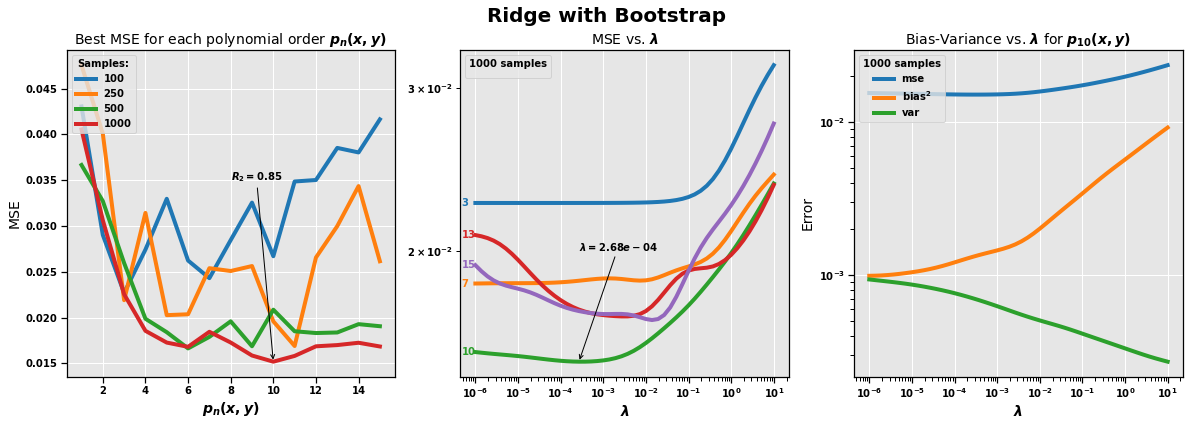

In [11]:
''' Plotting Ridge with Bootstrap '''

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=WIDE_FIG)
fig.suptitle("Ridge with Bootstrap", fontsize=LARGE, weight='bold')

''' Best MSE '''
ax = axes[0]
ax.set_title("Best MSE for each polynomial order $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("MSE")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')


# Data set for annotations and other subplots
idx = 3
sn = samples[idx]
ridge_bs_df, best_lambda, best_mse = results[idx]
best_mse_idx = np.argmin(best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = best_mse[best_mse_idx]
best_mse_lambda_val = best_lambda[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn-2, .035)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(best_mse, z[:sn])
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

''' MSE vs lambda '''
ax = axes[1]
ax.set_title(f"MSE vs. $\lambda$")
plot_orders = [3,7,10,13,15]
names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(ridge_bs_df['lambda'], ridge_bs_df[name])
    
for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
#ax.set_ylabel("MSE")
ax.set_xscale('log')
ax.set_yscale('log')

# Annotate best lambda
xytext = (best_mse_lambda_val, .02)
xy = (best_mse_lambda_val, best_mse_val)
ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

''' Bias-Variance '''
ax = axes[2]
pn = best_mse_pn
ax.set_title(f"Bias-Variance vs. $\lambda$ for $p_{{{pn}}}(x,y)$")
ax.plot(ridge_bs_df['lambda'], ridge_bs_df[f'test_mse_{pn}'])
ax.plot(ridge_bs_df['lambda'], ridge_bs_df[f'test_bias_{pn}'])
ax.plot(ridge_bs_df['lambda'], ridge_bs_df[f'test_var_{pn}'])
ax.legend(['mse', 'bias$^2$', 'var'], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Error")
ax.set_xscale('log')
ax.set_yscale('log')
    
plt.show()

In [12]:
'''Running Ridge with CV'''

lambdas = np.logspace(-7, -2, 50)
train_results = list()
test_results = list()
for sn in samples:
    X_down = X[:sn]
    z_down = z[:sn]
    ridge_k_df = run_ridge_kfold(X_down, z_down, k=10, polynomial_orders=polynomial_orders, lambdas=lambdas)
    best_lambda, best_mse = best_lambda_mse(df=ridge_k_df, polynomial_orders=polynomial_orders, col_prefix='train_mse_')
    train_results.append((ridge_k_df, best_lambda, best_mse))
    best_lambda, best_mse = best_lambda_mse(df=ridge_k_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
    test_results.append((ridge_k_df, best_lambda, best_mse))

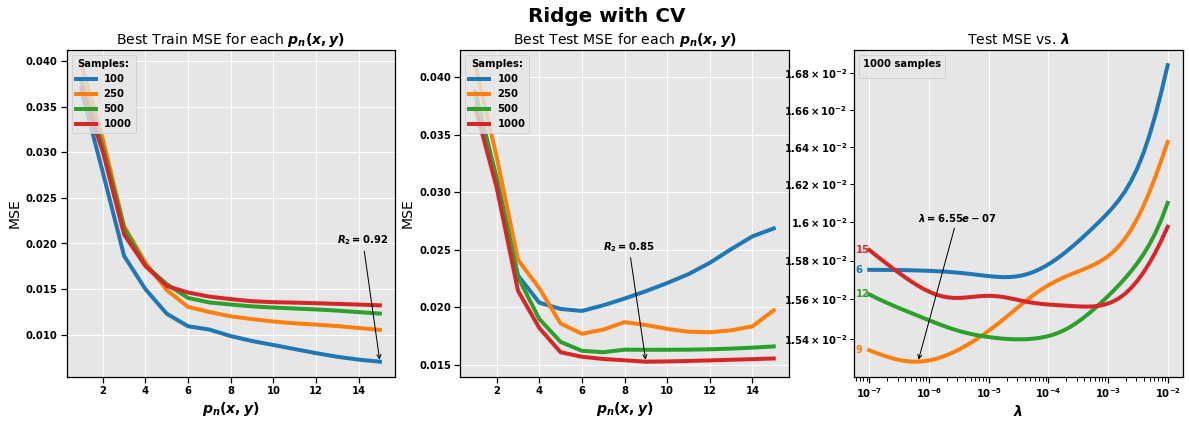

In [13]:
'''Plotting Ridge with CV'''

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=WIDE_FIG)
fig.suptitle("Ridge with CV", fontsize=LARGE, weight='bold')

''' Best Train MSE '''
ax = axes[0]
ax.set_title("Best Train MSE for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("MSE")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in train_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')

# Data set for annotations and other subplots
idx = 0
sn = samples[idx]
ridge_k_df, best_lambda, best_mse = train_results[idx]
best_mse_idx = np.argmin(best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = best_mse[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn-2, .020)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(best_mse, z[:sn])
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


''' Best Test MSE '''
ax = axes[1]
ax.set_title("Best Test MSE for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("MSE")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in test_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')

# Data set for annotations and other subplots
idx = 3
sn = samples[idx]
ridge_k_df, best_lambda, best_mse = test_results[idx]
best_mse_idx = np.argmin(best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = best_mse[best_mse_idx]
best_mse_lambda_val = best_lambda[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn-2, .025)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(best_mse, z[:sn])
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


''' Test MSE vs lambda '''
ax = axes[2]
ax.set_title(f"Test MSE vs. $\lambda$")
plot_orders = [6,9,12,15]
names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(ridge_k_df['lambda'], ridge_k_df[name])
    
for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
#ax.set_ylabel("MSE")
ax.set_xscale('log')
ax.set_yscale('log')

# Annotate best lambda
xytext = (best_mse_lambda_val, .016)
xy = (best_mse_lambda_val, best_mse_val)
ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})
    
plt.show()

In [14]:
best_mse_idx

8

In [15]:
best_mse_pn

9

In [16]:
1-VAR_EPS/np.var(z)

0.8511976812161686